--- COPENHAGEN BAYESIAN ESTIMATE ---
Posterior Mean: 1417.60
95% Credibility Interval: (np.float64(1391.6657176437711), np.float64(1443.529264670125))

--- OSLO BAYESIAN ESTIMATE ---
Posterior Mean: 1672.05
95% Credibility Interval: (np.float64(1604.0327438173485), np.float64(1740.0661093755243))

--- COMPARISON ---
Probability that Oslo Mean > Copenhagen Mean: 100.00%


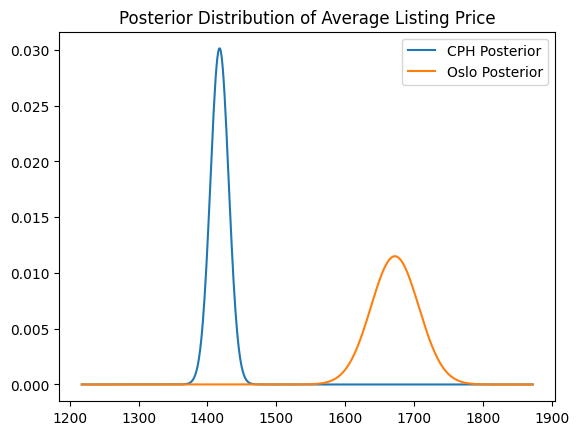

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# 1. LOAD AND PREPARE DATA
df = pd.read_csv("merged.csv", low_memory=False)

# Basic cleaning for this task
drop_cols = ['id', 'listing_url', 'scrape_id', 'picture_url', 'host_id', 'host_url']
df_clean = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Filter for the two cities
dk_data = df_clean[df_clean['city'] == 'Copenhagen'].copy()
no_data = df_clean[df_clean['city'] == 'Oslo'].copy()

# ==========================================================
# BAYESIAN INFERENCE (Price Estimation)
# ==========================================================
def calculate_posterior(price_series, prior_mu=1000, prior_std=500):
    prices = price_series.dropna()
    n = len(prices)
    data_mu = prices.mean()
    data_std = prices.std()
    
    # Conjugate Prior Update
    precision_prior = 1 / (prior_std**2)
    precision_data = n / (data_std**2)
    
    post_mu = (prior_mu * precision_prior + data_mu * precision_data) / (precision_prior + precision_data)
    post_std = np.sqrt(1 / (precision_prior + precision_data))
    
    return post_mu, post_std

# Run analysis
mu_cph, std_cph = calculate_posterior(dk_data['price_local'])
mu_oslo, std_oslo = calculate_posterior(no_data['price_local'])

# ADVANCED METRIC: Probability that Oslo is more expensive than Copenhagen
# (Difference of two normal distributions)
mu_diff = mu_oslo - mu_cph
std_diff = np.sqrt(std_cph**2 + std_oslo**2)
prob_oslo_higher = 1 - stats.norm.cdf(0, loc=mu_diff, scale=std_diff)

print(f"--- COPENHAGEN BAYESIAN ESTIMATE ---")
print(f"Posterior Mean: {mu_cph:.2f}")
print(f"95% Credibility Interval: {stats.norm.interval(0.95, mu_cph, std_cph)}")

print(f"\n--- OSLO BAYESIAN ESTIMATE ---")
print(f"Posterior Mean: {mu_oslo:.2f}")
print(f"95% Credibility Interval: {stats.norm.interval(0.95, mu_oslo, std_oslo)}")

print(f"\n--- COMPARISON ---")
print(f"Probability that Oslo Mean > Copenhagen Mean: {prob_oslo_higher:.2%}")

# Optional: Visualization for the report
x = np.linspace(min(mu_cph, mu_oslo) - 200, max(mu_cph, mu_oslo) + 200, 500)
plt.plot(x, stats.norm.pdf(x, mu_cph, std_cph), label='CPH Posterior')
plt.plot(x, stats.norm.pdf(x, mu_oslo, std_oslo), label='Oslo Posterior')
plt.title("Posterior Distribution of Average Listing Price")
plt.legend()
plt.savefig('bayesian_results.png')